## Introducción
Este cuaderno se centra en el procesamiento y análisis de un conjunto de datos de melanoma. Incluye pasos para la carga de datos, preprocesamiento, entrenamiento del modelo y evaluación.

### Indice
* [Model](##red-neuronal-simple)

In [61]:
%matplotlib inline

# imports
import torch
import torch.nn as nn
from torchvision.models import resnet50
import pandas as pd
import numpy as np

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

from sklearn.model_selection import train_test_split

In [62]:
import torch
# Configuración del dispositivo CUDA
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo configurado para usar: {device}")

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.1.1+cu121
Dispositivo configurado para usar: cuda
True
NVIDIA GeForce RTX 2060


In [63]:
# consts
cats = ["MEL","NV","BCC","AK","BKL","DF","VASC","SCC","UNK"]

base_path_csv = "./dataset"
base_path_img = "./dataset"

random_state=1

train_percent = .7
val_percent = .2
test_percent = .1

batch_size=64


## Configuración
Las siguientes celdas importan las librerías necesarias y definen constantes utilizadas a lo largo del cuaderno.

In [64]:
csv = pd.read_csv(f"{base_path_csv}/ISIC_2019_Training_GroundTruth.csv")

print("> Cantidad de elementos", csv.count(axis=1).size )
print("> Head de los datos del csv")
print(csv.head())

> Cantidad de elementos 25331
> Head de los datos del csv
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


In [65]:
header = list(csv.columns)
header.remove("image")

print("> Categorias")
print(header)

> Categorias
['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']


In [66]:

data = pd.DataFrame({"img":[], "cat": []}, dtype=int)
rows_list = []
for entry in csv.values:
    new_row = {"img": entry[0], "cat": np.where(entry==1.0)[0][0]-1}
    rows_list.append(new_row)

data = pd.DataFrame(rows_list)


print("> Cantidad de filas", csv.count(axis=1).size)
print("> Head de los datos en el formato que usa pytorch")
print(data.head())

> Cantidad de filas 25331
> Head de los datos en el formato que usa pytorch
            img  cat
0  ISIC_0000000    1
1  ISIC_0000001    1
2  ISIC_0000002    0
3  ISIC_0000003    1
4  ISIC_0000004    0


## Carga de Datos y Exploración Inicial
El conjunto de datos se carga desde un archivo CSV, y se realiza una exploración inicial para entender su estructura y contenidos.

In [67]:
counter = np.zeros(len(cats), dtype=int)

for elm in data.values:
    counter[int(elm[1])]+=1

print("> Cantidad de imagenes de cada tipo:")
print(counter)

> Cantidad de imagenes de cada tipo:
[ 4522 12875  3323   867  2624   239   253   628     0]


In [68]:
# counter = list(filter(lambda elm: elm > 0, counter))
# min_cat_size = min(counter)

min_cat_size = data.cat.value_counts().min()

print("> Cantidad mínima de imagenes de un tipo:")
print(min_cat_size)

> Cantidad mínima de imagenes de un tipo:
239


In [69]:
data = pd.DataFrame(data.groupby("cat").apply(lambda cat: cat.sample(min_cat_size, random_state=random_state)).reset_index(drop=True))

print("> Cantidad de elemntos:", data.count(axis=1).size )
print("> Datos equilibrados")
print(data.head())

> Cantidad de elemntos: 1912
> Datos equilibrados
            img  cat
0  ISIC_0032408    0
1  ISIC_0056876    0
2  ISIC_0033947    0
3  ISIC_0072989    0
4  ISIC_0054312    0


In [70]:
data = data.sample(frac=1, random_state=random_state)

print("> cantidad de elementos", data.count(axis=1).size)
print("> datos barajados")
print(data.head())

> cantidad de elementos 1912
> datos barajados
               img  cat
301   ISIC_0031379    1
137   ISIC_0069254    0
1799  ISIC_0058515    7
267   ISIC_0029388    1
186   ISIC_0070731    0


## Preprocesamiento y Análisis de Datos
Estas celdas manejan el preprocesamiento de datos, incluyendo la limpieza, equilibrio y preparación para el aprendizaje automático.

In [71]:
counter = np.zeros(len(cats), dtype=int)

for elm in data.values:
    counter[int(elm[1])]+=1

print("> Cantidad de imagenes de cada tipo:")
print(counter)

> Cantidad de imagenes de cada tipo:
[239 239 239 239 239 239 239 239   0]


In [72]:
# data.to_csv(f"{base_path_csv}/balanced_data.csv", index=False)

In [73]:
train_data, tmp = train_test_split(data, train_size=train_percent, stratify=data['cat'], shuffle=True, random_state=random_state)
val_data, test_data = train_test_split(tmp, test_size=test_percent/(test_percent+val_percent), stratify=tmp['cat'], shuffle=True, random_state=random_state)


print("> train", train_data.count(axis=1).size)
print(test_data.head())
print()

print("> val", val_data.count(axis=1).size)
print(val_data.head())
print()

print("> test", test_data.count(axis=1).size)
print(test_data.head())
print()

> train 1338
               img  cat
1073  ISIC_0072864    4
104   ISIC_0068581    0
450   ISIC_0059722    1
505   ISIC_0068758    2
1169  ISIC_0070967    4

> val 382
               img  cat
1251  ISIC_0025668    5
1498  ISIC_0027563    6
1838  ISIC_0025539    7
1790  ISIC_0071795    7
1551  ISIC_0033254    6

> test 192
               img  cat
1073  ISIC_0072864    4
104   ISIC_0068581    0
450   ISIC_0059722    1
505   ISIC_0068758    2
1169  ISIC_0070967    4


In [74]:
counter = np.zeros(len(cats), dtype=int)
for elm in train_data.values:
    counter[int(elm[1])]+=1

print("> train", train_data.count(axis=1).size, train_data.count(axis=1).size/data.count(axis=1).size)
print(counter, f"({counter[0]/train_data.count(axis=1).size})")
print()

counter = np.zeros(len(cats), dtype=int)
for elm in val_data.values:
    counter[int(elm[1])]+=1

print("> val", val_data.count(axis=1).size, val_data.count(axis=1).size/data.count(axis=1).size)
print(counter, f"({counter[0]/val_data.count(axis=1).size})")
print()

counter = np.zeros(len(cats), dtype=int)
for elm in test_data.values:
    counter[int(elm[1])]+=1

print("> test", test_data.count(axis=1).size, test_data.count(axis=1).size/data.count(axis=1).size)
print(counter, f"({counter[0]/test_data.count(axis=1).size})")
print()

> train 1338 0.6997907949790795
[167 167 168 167 167 167 167 168   0] (0.12481315396113603)

> val 382 0.1997907949790795
[48 48 47 48 48 48 48 47  0] (0.1256544502617801)

> test 192 0.100418410041841
[24 24 24 24 24 24 24 24  0] (0.125)


## División de Datos para el Entrenamiento del Modelo
El conjunto de datos se divide en conjuntos de entrenamiento, validación y prueba para prepararse para el entrenamiento del modelo.

In [75]:
# train_data.to_csv(f"{base_path_csv}/train_data.csv", index=False)
# val_data.to_csv(f"{base_path_csv}/val_data.csv", index=False)
# test_data.to_csv(f"{base_path_csv}/test_data.csv", index=False)

# creacion de un dataset personalizado

In [76]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import os

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.files = []
        for index, label in enumerate(self.classes):
            class_files = [(os.path.join(root_dir, label, file), index) for file in os.listdir(os.path.join(root_dir, label))]
            self.files.extend(class_files)
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [77]:

from torch.utils.data import random_split
from torchvision.datasets import ImageFolder


# Carga el conjunto de datos de entrenamiento sin ninguna normalización para calcular la media y la desviación estándar
unnormalized_transform = transforms.Compose([
    transforms.Resize((224,244)), 
    transforms.ToTensor()
])
unnormalized_dataset = ImageFolder(root='brain-tumor-mri-dataset/Training', transform=unnormalized_transform)
loader = DataLoader(unnormalized_dataset, batch_size=32, shuffle=False)

# Calcular la media y la desviación estándar
mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)
n_samples = 0

for images, _ in loader:
    # Asegúrate de que las imágenes están en el rango 0-1
    images = images / 255.0 if images.max() > 1 else images

    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean = images.mean(dim=[0, 2])
    std = images.std(dim=[0, 2])

    mean_sum += mean * batch_samples
    std_sum += std * batch_samples
    n_samples += batch_samples

mean = mean_sum / n_samples
std = std_sum / n_samples

# Transformaciones para el conjunto de entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((224,244)),             
     transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para el conjunto de validación y test (sin data augmentation)
test_valid_transforms = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Carga los conjuntos de datos usando ImageFolder
train_dataset = ImageFolder(root='brain-tumor-mri-dataset/Training', transform=train_transform)
test_dataset = ImageFolder(root='brain-tumor-mri-dataset/Testing', transform=test_valid_transforms)

# Divide el conjunto de entrenamiento en entrenamiento y validación
train_size = int((1 - val_percent - test_percent) * len(train_dataset))
val_size = int(val_percent * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size

train_dataset, val_dataset, _ = random_split(train_dataset, [train_size, val_size, test_size])

# Crea los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

# Acceder e imprimir las primeras 5 muestras del dataset
for i in range(5):
    image, label = train_dataset[i]
    print(f"Muestra {i}: Imagen - {type(image)}, Dimensiones - {image.size()}, Etiqueta - {label}")

# Imprimir los valores de la media y la desviación estándar
print(f"Media: {mean}, Desviación Estándar: {std}")



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True)

# Verificar DataLoader
for images, labels in train_loader:
    print(f"Batch de imágenes: {images.shape}, Batch de etiquetas: {labels.shape}")
    break 

Muestra 0: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 224, 224]), Etiqueta - 1
Muestra 1: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 224, 224]), Etiqueta - 3
Muestra 2: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 224, 224]), Etiqueta - 3
Muestra 3: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 224, 224]), Etiqueta - 0
Muestra 4: Imagen - <class 'torch.Tensor'>, Dimensiones - torch.Size([3, 224, 224]), Etiqueta - 2
Media: tensor([0.1854, 0.1854, 0.1855]), Desviación Estándar: tensor([0.1894, 0.1894, 0.1895])
Batch de imágenes: torch.Size([64, 3, 224, 224]), Batch de etiquetas: torch.Size([64])


In [78]:
# imports
import torch.nn as nn


## Red Neuronal simple 

In [79]:

import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Capa Dropout 
        self.dropout25 = nn.Dropout(0.25)
        self.dropout50 = nn.Dropout(0.5)

        # Capas Fully connected 
        # ajustado para 150x150
        self.fc1 = nn.Linear(in_features=128 * 18 * 18, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=8)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))


        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout25(x)

   
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout25(x)

       
        x = x.view(-1, 128 *18 * 18)

        x = F.relu(self.fc1(x))
        x = self.dropout50(x)

        x = self.fc2(x)
        return x

##model = CNN()


## Preparación del Modelo
Esta sección prepara el modelo de red neuronal usando PyTorch, incluyendo la definición de la arquitectura del modelo y los cargadores de datos.

In [80]:
def plot_loss(history):
    plt.plot(history)
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.show()

## Funciones de Entrenamiento y Evaluación
Aquí se definen las funciones para entrenar el modelo y evaluar su rendimiento.

In [81]:
def eval(model, test_loader, device, criterion):

    model.eval()

    total = 0
    correct = 0
    val_loss = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, cats in test_loader:
            imgs, cats = imgs.to(device), cats.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            val_loss += criterion(outputs, cats).item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(cats.cpu().numpy())

            total += cats.size(0)
            correct += (predicted == cats).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy on images: {acc:.2f}%')
    print(metrics.classification_report(all_targets, all_preds, zero_division=0))
    
    return all_preds, all_targets, val_loss / len(test_loader), acc


In [82]:
class EarlyStopping:
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopping = EarlyStopping(patience=10, min_delta=0.01)

In [83]:
def train_loop(model, train_loader, val_loader, optimizer, criterion, num_epoch, device,scheduler):
    train_accuracy_history = []
    val_accuracy_history = []
    train_loss_history = []
    val_loss_history = []
    best_val_accuracy=0.0
    for epoch in range(num_epoch):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for imgs, cats in train_loader:
            imgs, cats = imgs.to(device), cats.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, cats)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += cats.size(0)
            correct += (predicted == cats).sum().item()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        # Evaluación en el conjunto de validación
        preds, targets, val_loss, val_accuracy = eval(model, val_loader, device, criterion)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        # Guardar el mejor modelo basado en la métrica de validación
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        scheduler.step(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    print("Finished training")
    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history, preds, targets


## Utilidades Adicionales
Funciones de utilidad adicionales, como la detención temprana, se definen en esta sección.

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import ResNet50_Weights
from torchvision import models
from torchvision.models import resnet50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,4)  
resnet50(weights=ResNet50_Weights.DEFAULT)
if torch.cuda.device_count() > 1:  model = nn.DataParallel(model)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.1, verbose=True)
criterion = torch.nn.CrossEntropyLoss().to(device)
num_epochs = 300

train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history,preds,targets= train_loop(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epoch=num_epochs,
    device=device,
    scheduler=scheduler
)



C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\elena\Desktop\universidad\3º año\FSI\pythorch\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy on images: 66.55%
              precision    recall  f1-score   support

           0       1.00      0.32      0.49       275
           1       0.46      0.69      0.55       261
           2       0.75      0.90      0.82       309
           3       0.71      0.72      0.72       297

    accuracy                           0.67      1142
   macro avg       0.73      0.66      0.65      1142
weighted avg       0.74      0.67      0.65      1142

Epoch 1: Train Loss: 0.7601, Train Accuracy: 71.61%, Val Loss: 1.0601, Val Accuracy: 66.55%
Accuracy on images: 75.66%
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       275
           1       0.53      0.84      0.64       261
           2       0.92      0.76      0.83       309
           3       0.89      0.64      0.75       297

    accuracy                           0.76      1142
   macro avg       0.80      0.76      0.76      1142
weighted avg       0.81      0.76      

In [48]:

try:
    torch.save(model, 'modelo_completo_CNN_91.pth')

    torch.save(model.state_dict(), 'modelo_estado_CNN_91.pth')
    print("Modelo guardado correctamente.")
except Exception as e:
    print("Error al guardar el modelo:", e)


Modelo guardado correctamente.


## Conclusión


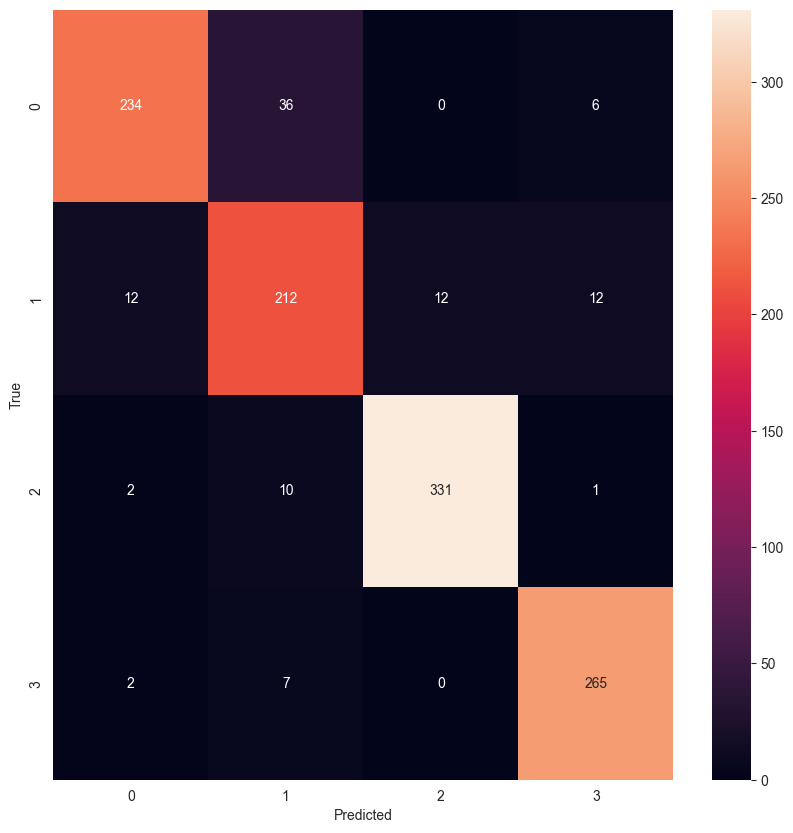

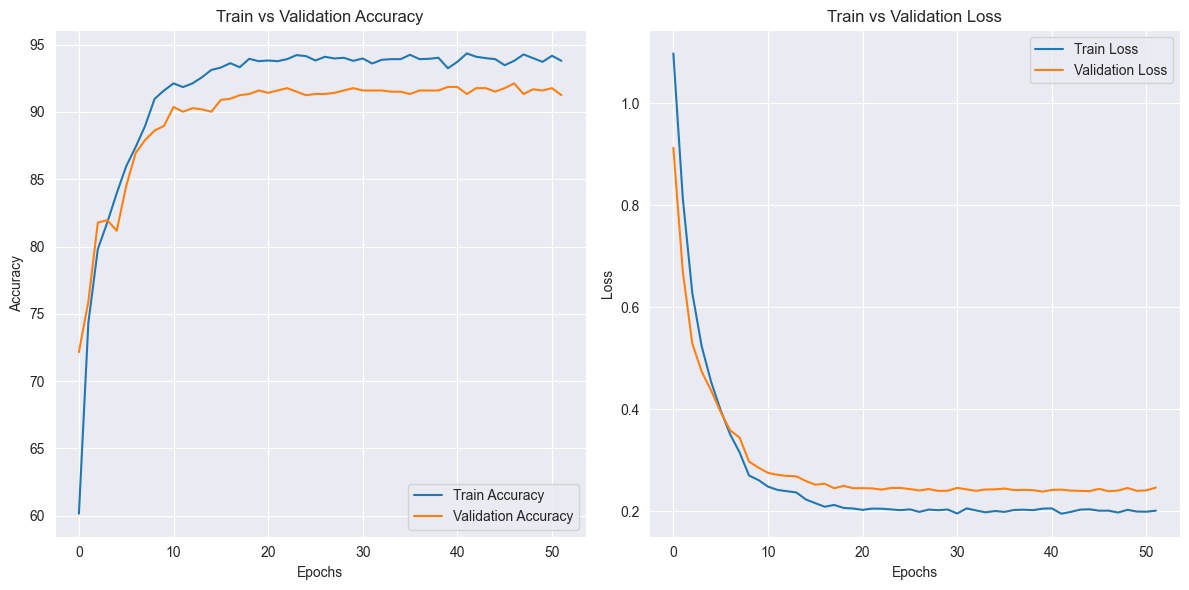

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# generar la matriz de confusión
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# Gráfico de la precisión de entrenamiento y validación
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Gráfico de la pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
